In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from sklearn.metrics import  f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Data Pre Processing

In [4]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [5]:
df['comment_text'] = df['comment_text'].apply(clean_text)

### Replacing Emojies

In [6]:
import emoji

def use_emoji(text):

    text=emoji.demojize(str(text))
    text=re.sub(':','',text)
    text=re.sub(r'\:(.*?)\:','',text)
    
    return text

df['comment_text'] = df['comment_text'].apply(use_emoji)

### Removing Accents

In [7]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii=re.sub(' +', ' ',(only_ascii.decode('utf-8')))
    return only_ascii

df['comment_text'] = df['comment_text'].apply(remove_accents)

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


## To find y values for converting problem into Binary

In [9]:
df_new = df.sum(axis=1,numeric_only=True)
y = df_new.values

y[y > 0] = 1
np.unique(y,return_counts=True)

(array([0, 1], dtype=int64), array([143346,  16225], dtype=int64))

To handle data imbalance we will try two approaches. 

- Oversampling using SMOTE
- Stratified Sampling

## Converting Text to Vector

In [10]:
x = df['comment_text'].values

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [25]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',strip_accents='unicode', use_idf=1, min_df=10)
x_train_vec = vector.fit_transform(x_train)
x_test_vec = vector.transform(x_test)

### Stratified Sampling

In [26]:
non_toxic = x_train[y_train == 0]
toxic = x_train[y_train == 1]

non_toxic.shape,toxic.shape

((114675,), (12981,))

In [27]:
# Randomly selecting 20000 non toxic comments.
ids = np.arange(non_toxic.shape[0])
np.random.shuffle(ids)
ids = ids[:20000]

non_toxic_selected = []

for i in ids:
    non_toxic_selected.append(non_toxic[i])

non_toxic_selected = np.asarray(non_toxic_selected)
print(non_toxic_selected.shape,toxic.shape)

(20000,) (12981,)


In [28]:
# Merging non toxic and toxic comments into one array
x_stratified = np.concatenate((non_toxic_selected,toxic))
print(x_stratified.shape)

(32981,)


In [29]:
y_stratified = np.zeros((32981,),dtype="int")
y_stratified[20000:] = 1

In [30]:
x_train.shape,x_stratified.shape

((127656,), (32981,))

In [31]:
vector2 = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',strip_accents='unicode', use_idf=1, min_df=10)
x_stratified_train_vec = vector2.fit_transform(x_stratified)
x_stratified_test_vec = vector2.transform(x_test)

### Oversampling using SMOTE

In [32]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [33]:
Counter(y_train)

Counter({1: 12981, 0: 114675})

In [34]:
sm = SMOTE(random_state=12)
x_sm, y_sm = sm.fit_sample(x_train_vec, y_train)
Counter(y_sm)

Counter({1: 114675, 0: 114675})

## Modelling

- First model will be trained using all of the data
- Second will be trained using stratified data
- Third will be trained using over-sampled data

After the training of all the 3 models we will test their performance on same test dataset.

In [35]:
lsvc = LinearSVC(max_iter=5000)
lsvc_stratified = LinearSVC(max_iter=5000)
lsvc_over_sample = LinearSVC(max_iter=5000)

In [36]:
lsvc.fit(x_train_vec,y_train)
lsvc_stratified.fit(x_stratified_train_vec,y_stratified)
lsvc_over_sample.fit(x_sm,y_sm)

LinearSVC(max_iter=5000)

In [38]:
y_pred = lsvc.predict(x_test_vec)
y_pred_stratified = lsvc_stratified.predict(x_stratified_test_vec)
y_pred_os = lsvc_over_sample.predict(x_test_vec)

In [39]:
y_pred.shape,y_pred_stratified.shape,y_pred_os.shape

((31915,), (31915,), (31915,))

In [40]:
f1_scores = []
f1_scores.append(f1_score(y_test,y_pred,average='weighted'))
f1_scores.append(f1_score(y_test,y_pred_os,average='weighted'))
f1_scores.append(f1_score(y_test,y_pred_stratified,average='weighted'))

f1_scores

[0.9602771765972054, 0.9202237258670158, 0.939440230537562]

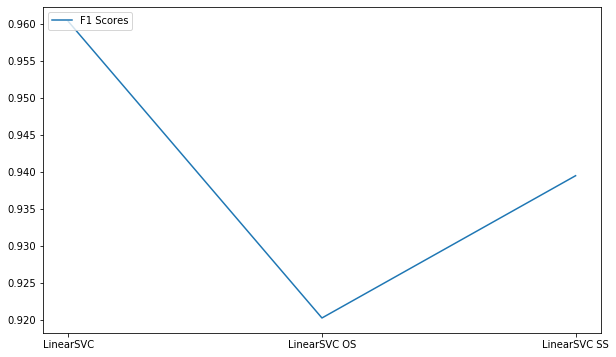

In [41]:
names = ['LinearSVC','LinearSVC OS','LinearSVC SS']
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)
# plt.plot(recall_scores)
plt.plot(f1_scores)
ax.set_xticks([0,1,2])
ax.set_xticklabels(names)
plt.legend(['F1 Scores'],loc='upper left')
plt.savefig(fname='data imbalance handling',dpi=1200)
plt.show()